# Import librairies et models

In [37]:
!pip install git+https://github.com/facebookresearch/segment-anything.git


  Cloning https://github.com/facebookresearch/segment-anything.git to c:\users\licor\appdata\local\temp\pip-req-build-gg38iqg8
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git 'C:\Users\licor\AppData\Local\Temp\pip-req-build-gg38iqg8'


In [38]:
# 2. Imports
import torch
from ultralytics import YOLO
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from transformers import CLIPProcessor, CLIPModel
from segment_anything import sam_model_registry, SamPredictor
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

## chargement du modele yolo_plate_only et yolo_food

In [39]:
# Charger ton modèle d'assiette
plate_model_path = r"D:\jedha\full_stack\projet\projet_final\models\yolo_plate_only_v8x_freeze8_contours_30px\weights\best.pt"
plate_model = YOLO(plate_model_path)


# Charger ton modèle food
food_model_path = r"D:\jedha\full_stack\projet\projet_final\models\yolov8x-seg_tuned_foodseg103_aug\weights\best.pt"
food_model = YOLO(food_model_path)

print("✅ Modèles chargés !")

✅ Modèles chargés !


## chargement du modele CLIP

In [40]:
# 1. Charger CLIP depuis HuggingFace
clip_model_name = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(clip_model_name)
clip_processor = CLIPProcessor.from_pretrained(clip_model_name)

# 2. Envoyer sur GPU si dispo
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip_model.to(device)


### Charger la liste d'aliments clip

In [41]:
# ✅ Liste plate directement utilisable pour clip
with open("food_classes_grouped.json", "r", encoding="utf-8") as f:
    candidate_labels = json.load(f)  

# calcul du nombre de pixels de l'image originale 


In [42]:
def get_image_dimensions_and_pixels(image_path):
    """
    Retourne les dimensions (hauteur, largeur) et le nombre total de pixels de l'image.

    Paramètre :
    - image_path : chemin vers l'image

    Retour :
    - hauteur (int)
    - largeur (int)
    - total_pixels (int)
    """
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image introuvable : {image_path}")

    h, w = image.shape[:2]
    total_pixels = h * w
    return h, w, total_pixels

# Detection contour assiette 

In [43]:
def get_contour_and_area(
    image_path,
    resize_for_detection=(640, 640),
    canny_threshold1=80,
    canny_threshold2=250,
    morph_kernel_size=5,
    approx_epsilon_factor=0.0001,
    morph_close=True
):
    """
    Retourne :
    - contour_assiette : array Nx2 dans la taille originale de l'image
    - aire_pixels : aire (en pixels) du masque issu de ce contour
    """

    if not os.path.exists(image_path):
        print(f"❌ Chemin invalide : {image_path}")
        return None, None

    image = cv2.imread(image_path)
    if image is None:
        print(f"⚠️ Image non lisible : {image_path}")
        return None, None

    h_orig, w_orig = image.shape[:2]
    w_resized, h_resized = resize_for_detection
    resized = cv2.resize(image, (w_resized, h_resized))

    scale_x = w_orig / w_resized
    scale_y = h_orig / h_resized

    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, canny_threshold1, canny_threshold2)

    if morph_close:
        kernel = np.ones((morph_kernel_size, morph_kernel_size), np.uint8)
        edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)

    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        print(f"⚠️ Aucun contour trouvé : {os.path.basename(image_path)}")
        return None, None

    contour_raw = max(contours, key=cv2.contourArea)
    epsilon = approx_epsilon_factor * cv2.arcLength(contour_raw, True)
    contour_resized = cv2.approxPolyDP(contour_raw, epsilon, False).reshape(-1, 2)

    # ⬅️ Recalibrer à la taille d’origine
    contour_assiette = np.stack([
        contour_resized[:, 0] * scale_x,
        contour_resized[:, 1] * scale_y
    ], axis=1).astype(int)

    # 🧮 Créer le masque à la taille originale
    mask_contour = np.zeros((h_orig, w_orig), dtype=np.uint8)
    cv2.drawContours(mask_contour, [contour_assiette], -1, 1, -1)  # filled contour

    aire_pixels = int(mask_contour.sum())

    return contour_assiette, aire_pixels


# Prediction assiette

In [44]:
def get_plate_bounding_box(image_path, plate_model):

    # 🔍 Prédiction YOLO
    plate_pred = plate_model(image_path)[0]

    if not plate_pred.boxes or len(plate_pred.boxes) == 0:
        print("❌ Aucun objet détecté.")
        return plate_pred, None, None, None, None, None

    image = cv2.imread(image_path)
    h, w = image.shape[:2]

    boxes = plate_pred.boxes.xyxy.cpu().numpy()
    classes = plate_pred.boxes.cls.cpu().numpy()
    confs = plate_pred.boxes.conf.cpu().numpy()
    names = plate_pred.names

    max_area = -1
    selected = {}

    for i in range(len(classes)):
        label = names[int(classes[i])]
        if label.startswith("class_ass"):

            mask_bool = None
            aire_pixels = 0

            # 🔁 S'il y a un masque de segmentation
            if plate_pred.masks is not None:
                mask = plate_pred.masks.data[i].cpu().numpy()
                mask_resized = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
                mask_bool = mask_resized > 0.5
                aire_pixels = int(mask_bool.sum())

                # 📦 Recalcul de la bbox directement depuis le masque
                yx = np.argwhere(mask_bool)
                if yx.size > 0:
                    y_min, x_min = yx.min(axis=0)
                    y_max, x_max = yx.max(axis=0)
                    x1, y1, x2, y2 = x_min, y_min, x_max, y_max
                else:
                    # fallback : coordonnées YOLO
                    x1, y1, x2, y2 = map(int, boxes[i])
                    aire_pixels = (x2 - x1) * (y2 - y1)
            else:
                # fallback complet si pas de masque
                x1, y1, x2, y2 = map(int, boxes[i])
                aire_pixels = (x2 - x1) * (y2 - y1)

            if aire_pixels > max_area:
                max_area = aire_pixels
                selected = {
                    "bbox": [x1, y1, x2, y2],
                    "class_name": label,
                    "score": float(confs[i]),
                    "contour": np.array([[x1, y1], [x2, y1], [x2, y2], [x1, y2]]),
                    "mask_bool": mask_bool,
                    "aire_pixels": aire_pixels
                }

    if not selected:
        print("❌ Aucune assiette détectée.")
        return plate_pred, None, None, None, None, None

    # ✅ Affichage
    print(f"✅ Assiette détectée : {selected['class_name']}")

    
    return (
        plate_pred,
        selected["bbox"],
        selected["class_name"],
        selected["score"],
        selected["contour"],
        selected["aire_pixels"]
    )



# Prediction food --> YOLO_FOOD + clip

In [45]:
def extract_and_label_food_in_plate_with_clip(
    image_path,
    contour_assiette,
    plate_pred,
    food_model,
    clip_model,
    clip_processor,
    candidate_labels,
    aire_assiette,
    device="cpu",
    seuil_clip=0.7,
    seuil_min=0.1,
    seuil_doublon=0.6
):

    def extract_crop(image, mask):
        yx = np.argwhere(mask)
        if yx.size == 0:
            return None
        y_min, x_min = yx.min(axis=0)
        y_max, x_max = yx.max(axis=0)
        masked = image.copy()
        for c in range(3):
            masked[..., c] = masked[..., c] * mask
        cropped = masked[y_min:y_max, x_min:x_max]
        return Image.fromarray(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))

    def clip_relabel(crop_pil_image):
        inputs = clip_processor(
            text=candidate_labels,
            images=crop_pil_image.resize((224, 224)),
            return_tensors="pt",
            padding=True
        ).to(device)
        outputs = clip_model(**inputs)
        logits = outputs.logits_per_image
        probs = logits.softmax(dim=1).detach().cpu().numpy().flatten()
        best_idx = int(np.argmax(probs))
        return candidate_labels[best_idx], float(probs[best_idx])

    image = cv2.imread(image_path)
    h, w = image.shape[:2]
    aire_image = h * w

    resultats = [
    {
        "label": "contour_assiette",
        "score": 1.0,
        "aire_pixels": aire_assiette,
        "pourcentage_assiette": 100.0,
        "pourcentage_image": round(100 * aire_assiette / aire_image, 2),
        "source": "CV2",
        "mask_bool": None
    }
]
    

    # Détection assiette via bbox (plate_pred)
    class_name = None
    score = 0.0
    x1 = y1 = x2 = y2 = 0
    boxes = plate_pred.boxes.xyxy.cpu().numpy()
    classes = plate_pred.boxes.cls.cpu().numpy()
    confs = plate_pred.boxes.conf.cpu().numpy()
    names = plate_pred.names

    for i in range(len(classes)):
        label = names[int(classes[i])]
        if label.startswith("class_ass"):
            x1_, y1_, x2_, y2_ = map(int, boxes[i])
            area = (x2_ - x1_) * (y2_ - y1_)
            class_name = label
            score = float(confs[i])
            x1, y1, x2, y2 = x1_, y1_, x2_, y2_
            break

    if class_name is not None:
        resultats.append({
            "label": class_name,
            "score": score,
            "aire_pixels": aire_assiette,
            "pourcentage_assiette": 100.0,
            "pourcentage_image": round(100 * aire_assiette / aire_image, 2),
            "source": "yolo_plate",
            "mask_bool": None
        })

    # Détection aliments (YOLO)
    result_food = food_model(image_path)[0]
    masks = result_food.masks.data.cpu().numpy() if result_food.masks is not None else []
    classes_food = result_food.boxes.cls.cpu().numpy() if result_food.boxes else []
    confs_food = result_food.boxes.conf.cpu().numpy() if result_food.boxes else []
    names_food = result_food.names

    overlay = image.copy()

    for mask, cls_id, conf in zip(masks, classes_food, confs_food):
        mask_resized = cv2.resize(mask, (w, h), interpolation=cv2.INTER_NEAREST)
        masked_inside = mask_resized > 0.5

        if masked_inside.sum() == 0:
            continue

        aire_pixels = int(masked_inside.sum())
        pourc_assiette = round(100 * aire_pixels / aire_assiette, 2)
        pourc_image = round(100 * aire_pixels / aire_image, 2)

        label = names_food[int(cls_id)]
        score_food = float(conf)
        source = "yolo_food"

        # Relabel via CLIP
        if score_food < seuil_clip:
            crop = extract_crop(image, masked_inside)
            if crop is not None:
                label_clip, score_clip = clip_relabel(crop)
                print(f"🔁 CLIP : {label} → {label_clip} ({score_clip:.2f})")
                label = label_clip
                score_food = score_clip
                source = "clip"

        if score_food < seuil_min:
            print(f"⚠️ Ignoré : {label} avec score {score_food:.2f}")
            continue

        is_duplicate = False
        for prev in resultats:
            if prev["label"] == label and prev["mask_bool"] is not None:
                intersection = np.logical_and(masked_inside, prev["mask_bool"]).sum()
                union = np.logical_or(masked_inside, prev["mask_bool"]).sum()
                iou = intersection / union if union > 0 else 0
                if iou > seuil_doublon:
                    print(f"⚠️ Doublon ignoré : {label} (IoU={iou:.2f})")
                    is_duplicate = True
                    break
        if is_duplicate:
            continue

        resultats.append({
            "label": label,
            "score": score_food,
            "aire_pixels": aire_pixels,
            "pourcentage_assiette": pourc_assiette,
            "pourcentage_image": pourc_image,
            "source": source,
            "mask_bool": masked_inside
        })

        color = np.random.randint(0, 255, size=3).astype(np.uint8)
        overlay[masked_inside] = (
            0.5 * overlay[masked_inside] + 0.5 * color
        ).astype(np.uint8)

        mask_uint8 = (masked_inside * 255).astype(np.uint8)
        contours, _ = cv2.findContours(mask_uint8, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(overlay, contours, -1, (0, 0, 0), 3)

        yx = np.argwhere(masked_inside)
        y, x = yx.mean(axis=0).astype(int)
        cv2.putText(overlay, f"{label} ({score_food:.2f})", (x, y),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    # Affichage final
    if class_name is not None:
        cv2.rectangle(overlay, (x1, y1), (x2, y2), (0, 255, 255), 3)
        cv2.putText(overlay, f"{class_name} ({score:.2f})", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)

    # 🔵 Affichage du contour réel de l’assiette (venant de get_contour_assiette)
    if contour_assiette is not None:
        cv2.polylines(
            overlay,
            [contour_assiette.astype(np.int32)],
            isClosed=True,
            color=(0, 255, 0),  # vert
            thickness=5
        )


    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title("Aliments (YOLO + CLIP) avec assiette")
    plt.show()

    df = pd.DataFrame(resultats)
    if "mask_bool" in df.columns:
        df = df.drop(columns="mask_bool")

    return df



# Scan image 


In [46]:
seuil_clip=0.75      # 🔁 Seuil de prediction confiance en dessous duquel on relabel avec CLIP
seuil_min=0.5       # ⚠️ Seuil predictin minimum sous lequel l'aliment est ignoré
seuil_doublon=0.8    # ♻️ Seuil d’IoU (Intersection over Union) au-dessus duquel on considère un doublon 

analyse de l'image
🔢 Pixels totaux : 12484800

🔍 Récupération du contour de l’assiette...
🔷 Contour assiette : (582, 2)
📐 Aire du contour : 3889157 pixels

🔍 Détection de l’assiette avec YOLO...

image 1/1 D:\jedha\full_stack\projet\projet_final\database\dataset_test\ass_270_rice_potatoes_2.jpg: 480x640 1 fork, 1 class_ass_270, 790.6ms
Speed: 3.5ms preprocess, 790.6ms inference, 3.4ms postprocess per image at shape (1, 3, 480, 640)
✅ Assiette détectée : class_ass_270

detection des aliments avec YOLO + clip...

image 1/1 D:\jedha\full_stack\projet\projet_final\database\dataset_test\ass_270_rice_potatoes_2.jpg: 480x640 1 rice, 1 potato, 675.5ms
Speed: 2.3ms preprocess, 675.5ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


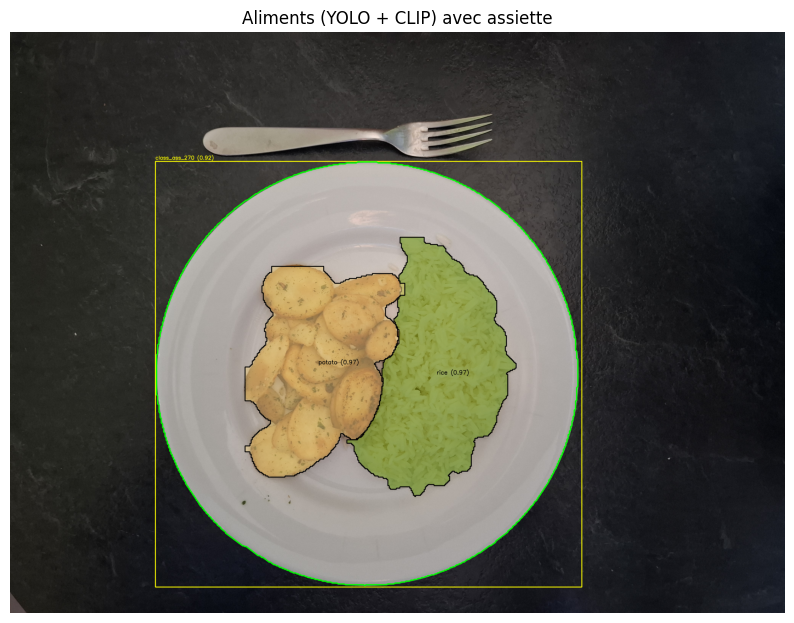

,label,score,aire_pixels,pourcentage_assiette,pourcentage_image,source
0,contour_assiette,1.000000,3889157,100.00,31.15,CV2
1,class_ass_270,0.916049,3889157,100.00,31.15,yolo_plate
2,rice,0.968751,693909,17.84,5.56,yolo_food
3,potato,0.966775,656647,16.88,5.26,yolo_food


In [47]:
image_path = r"D:\jedha\full_stack\projet\projet_final\database\dataset_test\ass_270_rice_potatoes_2.jpg" 


#composition de l'image 
print ("analyse de l'image")
_, _, total_pixels = get_image_dimensions_and_pixels(image_path)
print(f"🔢 Pixels totaux : {total_pixels}")


# Récupère le contour de l’assiette et son aire
print ("\n🔍 Récupération du contour de l’assiette...")
contour_array, aire_contour = get_contour_and_area(image_path)

# Affichage si besoin
print("🔷 Contour assiette :", contour_array.shape)
print("📐 Aire du contour :", aire_contour, "pixels")


# Appel de la fonction avec le modèle de détection d’assiette
print ("\n🔍 Détection de l’assiette avec YOLO...")
plate_pred, bbox, class_name, score, contour, aire_pixels = get_plate_bounding_box(image_path, plate_model)

print ("\ndetection des aliments avec YOLO + clip...") 
df_resultats = extract_and_label_food_in_plate_with_clip(
    image_path=image_path,
    contour_assiette=contour_array,  # array Nx2
    plate_pred=plate_pred,              # sortie YOLO assiette
    food_model=food_model,
    clip_model=clip_model,
    clip_processor=clip_processor,
    candidate_labels=candidate_labels,
    aire_assiette=aire_contour,        # issue de cv2.contourArea(contour_assiette)
    device="cpu",                        # ou "cuda" si disponible
    seuil_clip=seuil_clip,
    seuil_min=seuil_min,
    seuil_doublon=seuil_doublon
)

display(df_resultats)


analyse de l'image
🔢 Pixels totaux : 12484800

🔍 Récupération du contour de l’assiette...
🔷 Contour assiette : (629, 2)
📐 Aire du contour : 4688319 pixels

🔍 Détection de l’assiette avec YOLO...

image 1/1 D:\jedha\full_stack\projet\projet_final\database\dataset_etalonne\ass_195_potatoes_4.jpg: 640x480 1 fork, 1 class_ass_195, 652.6ms
Speed: 2.3ms preprocess, 652.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)
✅ Assiette détectée : class_ass_195

detection des aliments avec YOLO + clip...

image 1/1 D:\jedha\full_stack\projet\projet_final\database\dataset_etalonne\ass_195_potatoes_4.jpg: 640x480 1 potato, 690.1ms
Speed: 2.2ms preprocess, 690.1ms inference, 3.1ms postprocess per image at shape (1, 3, 640, 480)


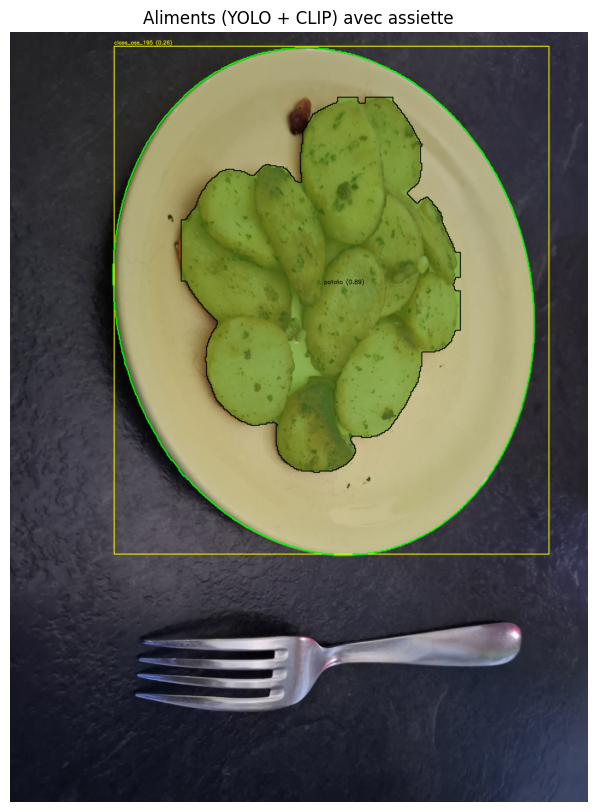

,label,score,aire_pixels,pourcentage_assiette,pourcentage_image,source
0,contour_assiette,1.000000,4688319,100.00,37.55,CV2
1,class_ass_195,0.262622,4688319,100.00,37.55,yolo_plate
2,potato,0.892368,1989624,42.44,15.94,yolo_food


In [48]:
image_path = r"D:\jedha\full_stack\projet\projet_final\database\dataset_etalonne\ass_195_potatoes_4.jpg" 


#composition de l'image 
print ("analyse de l'image")
_, _, total_pixels = get_image_dimensions_and_pixels(image_path)
print(f"🔢 Pixels totaux : {total_pixels}")


# Récupère le contour de l’assiette et son aire
print ("\n🔍 Récupération du contour de l’assiette...")
contour_array, aire_contour = get_contour_and_area(image_path)

# Affichage si besoin
print("🔷 Contour assiette :", contour_array.shape)
print("📐 Aire du contour :", aire_contour, "pixels")


# Appel de la fonction avec le modèle de détection d’assiette
print ("\n🔍 Détection de l’assiette avec YOLO...")
plate_pred, bbox, class_name, score, contour, aire_pixels = get_plate_bounding_box(image_path, plate_model)

print ("\ndetection des aliments avec YOLO + clip...") 
df_resultats = extract_and_label_food_in_plate_with_clip(
    image_path=image_path,
    contour_assiette=contour_array,  # array Nx2
    plate_pred=plate_pred,              # sortie YOLO assiette
    food_model=food_model,
    clip_model=clip_model,
    clip_processor=clip_processor,
    candidate_labels=candidate_labels,
    aire_assiette=aire_contour,        # issue de cv2.contourArea(contour_assiette)
    device="cpu",                        # ou "cuda" si disponible
    seuil_clip=seuil_clip,
    seuil_min=seuil_min,
    seuil_doublon=seuil_doublon
)

display(df_resultats)


analyse de l'image
🔢 Pixels totaux : 11860560

🔍 Récupération du contour de l’assiette...
🔷 Contour assiette : (651, 2)
📐 Aire du contour : 5555379 pixels

🔍 Détection de l’assiette avec YOLO...

image 1/1 D:\jedha\full_stack\projet\projet_final\database\dataset_test\20250329_121450.jpg: 640x512 1 fork, 1 class_ass_270, 724.3ms
Speed: 2.7ms preprocess, 724.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 512)
✅ Assiette détectée : class_ass_270

detection des aliments avec YOLO + clip...

image 1/1 D:\jedha\full_stack\projet\projet_final\database\dataset_test\20250329_121450.jpg: 640x512 1 egg, 1 shrimp, 1 rice, 1 tofu, 601.5ms
Speed: 3.2ms preprocess, 601.5ms inference, 4.5ms postprocess per image at shape (1, 3, 640, 512)
🔁 CLIP : tofu → leek (0.72)
🔁 CLIP : egg → gratin (0.16)
⚠️ Ignoré : gratin avec score 0.16


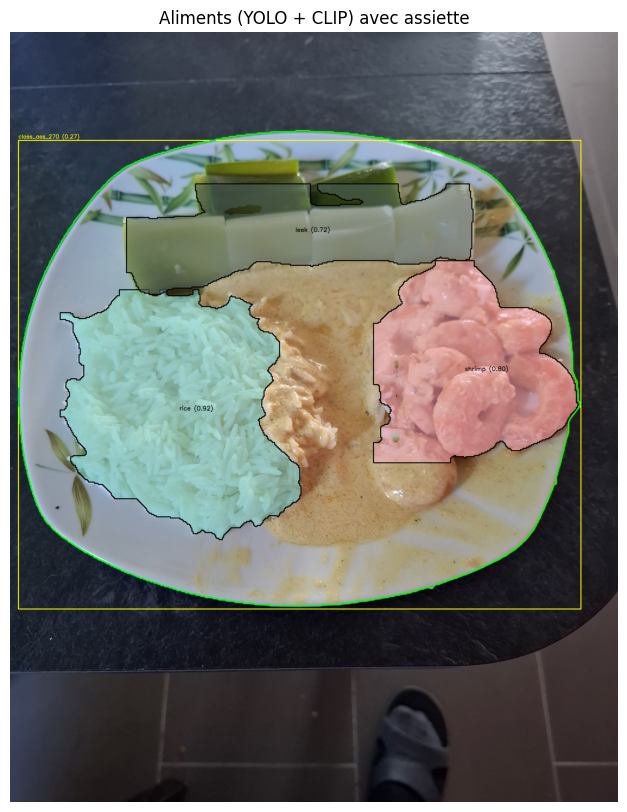

,label,score,aire_pixels,pourcentage_assiette,pourcentage_image,source
0,contour_assiette,1.000000,5555379,100.00,46.84,CV2
1,class_ass_270,0.267562,5555379,100.00,46.84,yolo_plate
2,rice,0.919018,1082171,19.48,9.12,yolo_food
3,shrimp,0.801130,765698,13.78,6.46,yolo_food
4,leek,0.718860,656948,11.83,5.54,clip


In [49]:
image_path = r"D:\jedha\full_stack\projet\projet_final\database\dataset_test\20250329_121450.jpg" 


#composition de l'image 
print ("analyse de l'image")
_, _, total_pixels = get_image_dimensions_and_pixels(image_path)
print(f"🔢 Pixels totaux : {total_pixels}")


# Récupère le contour de l’assiette et son aire
print ("\n🔍 Récupération du contour de l’assiette...")
contour_array, aire_contour = get_contour_and_area(image_path)

# Affichage si besoin
print("🔷 Contour assiette :", contour_array.shape)
print("📐 Aire du contour :", aire_contour, "pixels")


# Appel de la fonction avec le modèle de détection d’assiette
print ("\n🔍 Détection de l’assiette avec YOLO...")
plate_pred, bbox, class_name, score, contour, aire_pixels = get_plate_bounding_box(image_path, plate_model)

print ("\ndetection des aliments avec YOLO + clip...") 
df_resultats = extract_and_label_food_in_plate_with_clip(
    image_path=image_path,
    contour_assiette=contour_array,  # array Nx2
    plate_pred=plate_pred,              # sortie YOLO assiette
    food_model=food_model,
    clip_model=clip_model,
    clip_processor=clip_processor,
    candidate_labels=candidate_labels,
    aire_assiette=aire_contour,        # issue de cv2.contourArea(contour_assiette)
    device="cpu",                        # ou "cuda" si disponible
    seuil_clip=seuil_clip,
    seuil_min=seuil_min,
    seuil_doublon=seuil_doublon
)

display(df_resultats)
